# Introduction

In [6]:
%matplotlib widget

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Gradient Descent

Gradient descent is a first order optimization algorithm for finding the minimum of a differentiable function. The algorithm steps in the opposite direction of the gradient of a function at a given point. The algorithm has tremendously interesting convergence properties, especially when applied to neural networks.

In simple terms gradient descent works like this:
- Generate a prediction
- Calculate the loss
- Compute the gradient. This can be done either explicitly or using compiler assisted autodifferentiation.
- Adjust weights and biases in proportion to the learning rate
- Reset gradients back to zero

<img src="https://upload.wikimedia.org/wikipedia/commons/f/ff/Gradient_descent.svg" width=400 height=400/>

In [3]:
# Let us create some example data to make predictions on

xt = np.array([
    [800, 1200, 700], 
    [900, 1500, 800],
    [450, 800, 300],
    [650, 1050, 500]], dtype="float32")

yt = np.array([
    [3000], 
    [3500],
    [1500], 
    [2000]], dtype="float32")

# torch uses tensor objects which are type-stable n-dim matrices
# they can handle many number types 8-bit unsigned to 128 bit complex

x = torch.from_numpy(xt)
y = torch.from_numpy(yt)

train = TensorDataset(x, y)

### Neural Networks
We will be using neural networks (NNs) in this notebook because Python libraries are amenable to exemplifying gradient descent with NNs. Nevertheles, for the sake of these exercises, you may think of them as ordinary (linear) regressors.

In [4]:
# Let us create a very simple model with three inputs and one output

m = nn.Linear(3, 1)
print(m.weight)

Parameter containing:
tensor([[-0.5700, -0.5526, -0.2101]], requires_grad=True)


In [5]:
# we run the model on our data and calculate the MSE
# notice that the resulting loss is very high

ŷ = m(x)

l = F.mse_loss(ŷ, y)

print(l.data)

tensor(14437006.)


### Gradients and Neural Networks

The "gradient" we wish to look at is the difference between the co-domain of an objective function (the ground truth) and the co-domain of our model (the prediction). However, when it comes to NNs, there are other types of gradients of interest, and to avoid confusion we need to quickly clarify what they are.

When training a NN, one must calculate the prediction error with respect to every parameter, which involves performing analytical differentiation across sequences of parameters. The resulting partial-derivatives then inform how the parameters of the model are to be adjusted accordingly.

Many machine learning courses tend to teach NNs by asking students to implement differentiation algorithms using analytical methods such as the [chain rule](https://en.wikipedia.org/wiki/Chain_rule). However, modern NN implementations use compiler assisted automatic differentiation (AD) that can calculate gradients across for-loops, branches, and recursion! So although one initially might think of DNNs as merely a set of matrix multiplications, convolutions, and other layers, with AD we can think of those layers as merely being special cases of differentiable functions. For those interested, here is a good introduction to modern AD https://arxiv.org/abs/1810.07951

For the sake of this notebook, we will be focusing on the "gradient" as merely the difference between the truth and the model prediction.

In [6]:
# Torch can automatically calculate the gradient for us

l.backward()

In [7]:
# the tensor for the weight now has a gradient value applied

m.weight.grad

tensor([[-5462722., -8825744., -4600151.]])

In [8]:
# Let us train the network 

for i in range(10000): # adjust the weights (parameters) 100 times
    ŷ = m(x) # make prediction
    l = F.mse_loss(ŷ, y) # calculate loss
    l.backward() # calculate initial leaf (output) gradient
    with torch.no_grad(): # don't track gradients automatically
        # the steps below are scaled by 1e-7
        # this scaling factor is what is known as the "learning rate"
        m.weight -= m.weight.grad * 1e-7 # apply the gradient to the weight
        m.bias -= m.bias.grad * 1e-7 # apply the gardient to the bias
        m.weight.grad.zero_() # reset the gradient
        m.bias.grad.zero_()

In [9]:
# as we can see, the model performs much better after training

ŷ = m(x)

l = F.mse_loss(ŷ, y)

print(l.data)

tensor(12608.5449)


# The loss landscape

In [10]:
# we can plot the loss landscape by generating a new model with gaussian random parameters
# and using that model to perturb the trained model by varying amounts as per https://arxiv.org/pdf/1712.09913.pdf
# 

mr = nn.Linear(3, 1) # this is our random model
mp = nn.Linear(3, 1) # this is our perturbed model

lossval = []
for i in np.linspace(-1, 1, 50):
    mp.weight.data = (1-i) * m.weight.data + i * mr.weight.data
    mp.bias.data = (1-i) * m.bias.data + i * mr.bias.data
    lossval.append(F.mse_loss(mp(x), y).item())

Text(0, 0.5, 'loss')

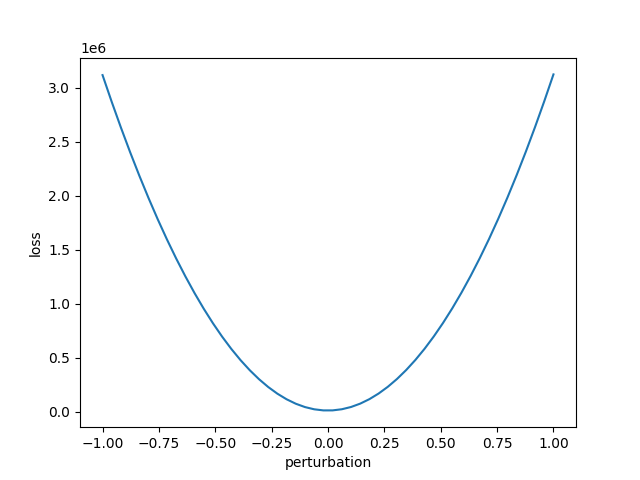

In [11]:
# clear old visualizations
plt.close('all')

# visualize the points
fig, ax = plt.subplots()
plt.plot(np.linspace(-1, 1, 50), lossval)
ax.set_xlabel('perturbation')
ax.set_ylabel('loss')

# This is the "landscape" which our model "descended" into!

# more advanced landscapes

In [12]:
# this is a simple monkey saddle
# https://en.wikipedia.org/wiki/Monkey_saddle

x, y = np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50))

zmap = x**3 - 3 * x * y**2 + 2

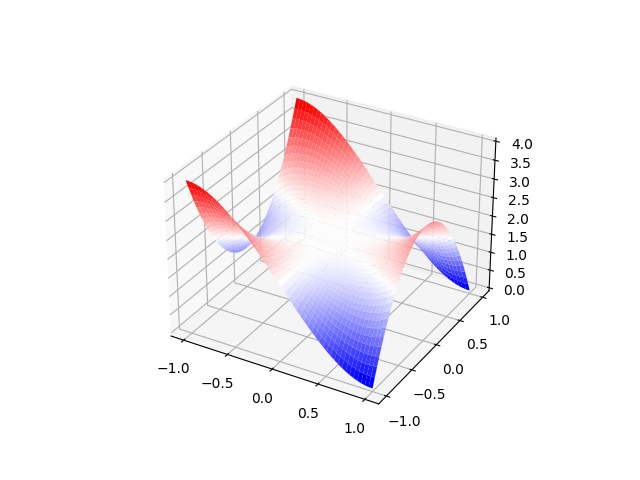

In [13]:
# clear old visualizations
plt.close('all')

# visualize the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, zmap, rstride=1, cstride=1, 
                cmap='bwr', linewidth=0.4, antialiased=True)

plt.show()

# Stochastic Gradient Descent (SGD)

Stochastic gradient descent is a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). Especially in high-dimensional optimization problems this reduces the very high computational burden, achieving faster iterations in trade for a lower convergence rate.

In [14]:
# this helper function will allow us to use optimizers 
# provided with pytorch so we can experiment and compare them

def drawpath(pos, opt, steps):
    xp, yp, zp = [], [], []
    for epoch in range(steps):
        opt.zero_grad()            # reset the gradients
        xp.append(pos[0].item())   # remember x position
        yp.append(pos[1].item())   # remember y position
        z = monke(pos[0], pos[1])  # calcucate z
        zp.append(z.item())        # remember z
        z.backward()               # calculate gradients
        opt.step()                 # adjust x and y
    return xp, yp, zp

def monke(x, y):
    z = x**3 - 3 * x * y**2 + 2
    return torch.clip(z, 0, None)

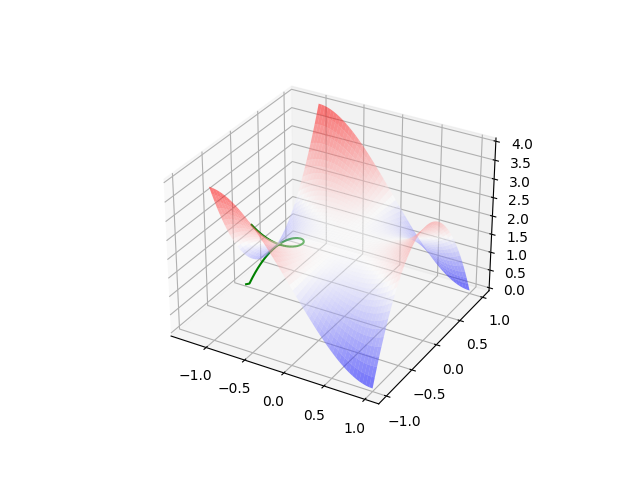

In [15]:
# let us begin in the corner of the monkey saddle
# we optimize using ordinary SGD
# we provide a learning rate of 0.01 and iterate for 200 steps

pos = torch.nn.Parameter(torch.Tensor([-0.55, -0.9]), requires_grad=True)
opt = torch.optim.SGD([pos], lr=0.01)
xp, yp, zp = drawpath(pos, opt, 200)

# clear old visualizations
plt.close('all')

# visualize the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, zmap, rstride=1, cstride=1, alpha=0.5,
                cmap='bwr', linewidth=0.4, antialiased=True)
ax.plot(xp, yp, zp, color='green')
plt.show()    

# note how our model traverses the landscape and falls off

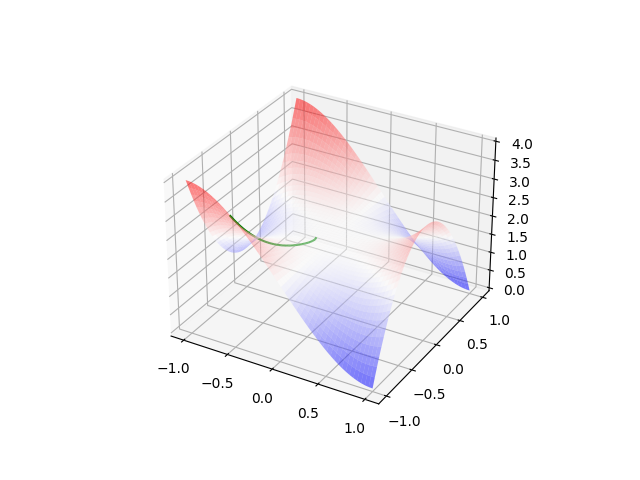

In [16]:
# this time we adjust the starting position ever so slightly
# and run the same experiment again

pos = torch.nn.Parameter(torch.Tensor([-0.55, -0.95]), requires_grad=True)
opt = torch.optim.SGD([pos], lr=0.01)
xp, yp, zp = drawpath(pos, opt, 200)

# clear old visualizations
plt.close('all')

# visualize the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, zmap, rstride=1, cstride=1, alpha=0.5,
                cmap='bwr', linewidth=0.4, antialiased=True)
ax.plot(xp, yp, zp, color='green')
plt.show()

# why do you think the model stopped moving in the middle?
# do you think the model will continue moving if we iterate more?

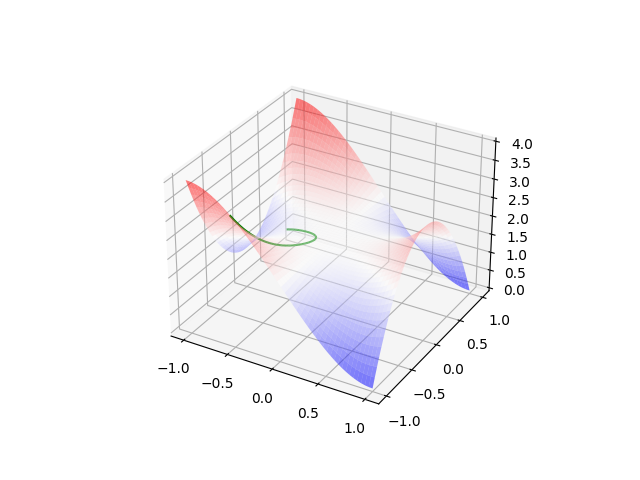

In [17]:
# let us try the same experiment we ran before but with twice as many iterations

pos = torch.nn.Parameter(torch.Tensor([-0.55, -0.95]), requires_grad=True)
opt = torch.optim.SGD([pos], lr=0.01)
xp, yp, zp = drawpath(pos, opt, 400)

# clear old visualizations
plt.close('all')

# visualize the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, zmap, rstride=1, cstride=1, alpha=0.5,
                cmap='bwr', linewidth=0.4, antialiased=True)
ax.plot(xp, yp, zp, color='green')
plt.show()

# this model is moving very very slowly across that saddle point

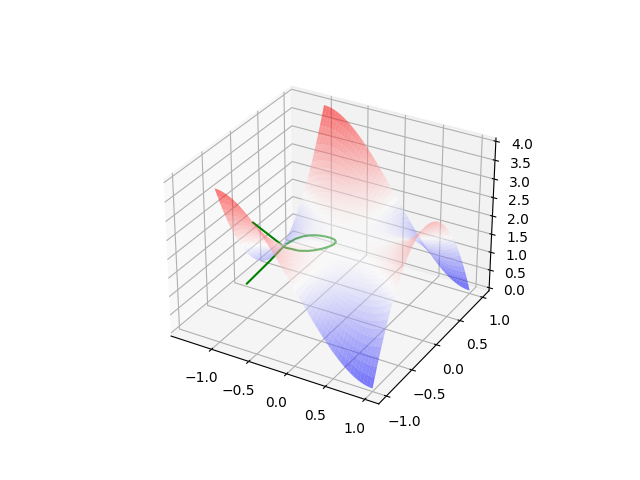

In [18]:
# let us try the same experiment but with a higher learning rate

pos = torch.nn.Parameter(torch.Tensor([-0.55, -0.95]), requires_grad=True)
opt = torch.optim.SGD([pos], lr=0.1)
xp, yp, zp = drawpath(pos, opt, 200)

# clear old visualizations
plt.close('all')

# visualize the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, zmap, rstride=1, cstride=1, alpha=0.5,
                cmap='bwr', linewidth=0.4, antialiased=True)
ax.plot(xp, yp, zp, color='green')
plt.show()

# this looks promising, however, high learning rates can be very erratic.
# Before we experiment with erratic paths let us look at an improvement to SGD

# Momentum
Let us be specific. The update rule in ordinary SGD is

$ θ_{t+1} = θ_t - η Δloss(θ) $

Momentum is essentially a small change to the SGD parameter update so that movement hrough the 'parameter space' is averaged over multiple steps. This is done by introducing a velocity component. Momentum speeds up movement along directions of strong improvement and also helps the model avoid local minima. It is intuitively related to the concept of momentum in physics. With momentum, the SGD update rule is changed to:

$ v_{t+1} = μv_t - η Δloss(θ) $

$ θ_{t+1} = θ_t + v_{t+1} $

where $v$ is velocity and $\mu$ is the momentum parameter which controls how fast velocity can change and how much the local gradient influences long term movement.

http://proceedings.mlr.press/v28/sutskever13.pdf

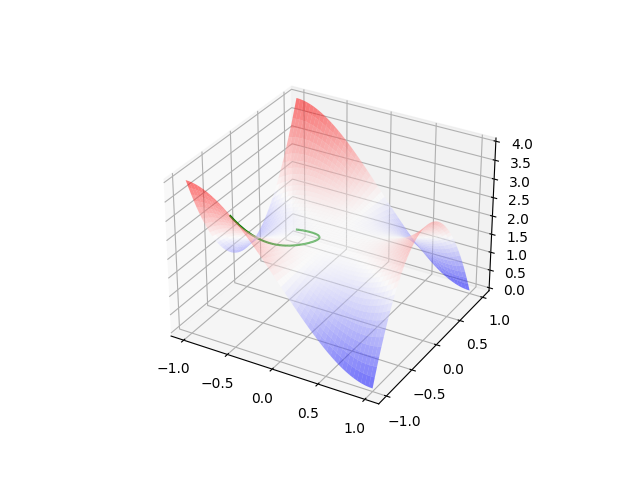

In [19]:
# let us try the same experiment we ran before but with momentum

pos = torch.nn.Parameter(torch.Tensor([-0.55, -0.95]), requires_grad=True)
opt = torch.optim.SGD([pos], lr=0.01, momentum=0.6)
xp, yp, zp = drawpath(pos, opt, 200)

# clear old visualizations
plt.close('all')

# visualize the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, zmap, rstride=1, cstride=1, alpha=0.5,
                cmap='bwr', linewidth=0.4, antialiased=True)
ax.plot(xp, yp, zp, color='green')
plt.show()

# the model made it a bit past the saddle point despite the low learning rate!
# what happens if we increase the momentum?

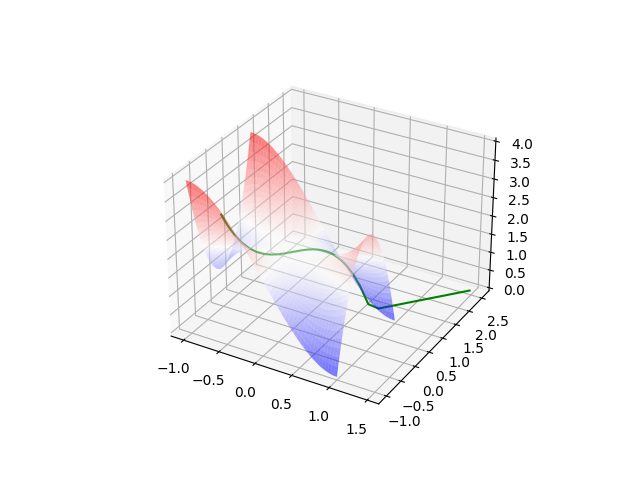

In [20]:
# can we make it across the landscape with fewer iterations if we increase momentum?

pos = torch.nn.Parameter(torch.Tensor([-0.55, -0.95]), requires_grad=True)
opt = torch.optim.SGD([pos], lr=0.01, momentum=0.9)
xp, yp, zp = drawpath(pos, opt, 200)

# clear old visualizations
plt.close('all')

# visualize the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, zmap, rstride=1, cstride=1, alpha=0.5,
                cmap='bwr', linewidth=0.4, antialiased=True)
ax.plot(xp, yp, zp, color='green')
plt.show()

# this time the model made it across the landscape instead of turning around
# let us look at more improvements to SGD

# Adaptive Moment Estimation

These algorithms adapt the learning rate to different parameters.

- RMSProp

This and similar approaches store an exponentially decaying average of past squared gradients $ v $.
https://arxiv.org/pdf/1308.0850v5.pdf

- ADAM

This and similar approaches also keep a decaying average of past squared gradients $ μ $.
https://arxiv.org/abs/1412.6980


https://pytorch.org/docs/stable/optim.html

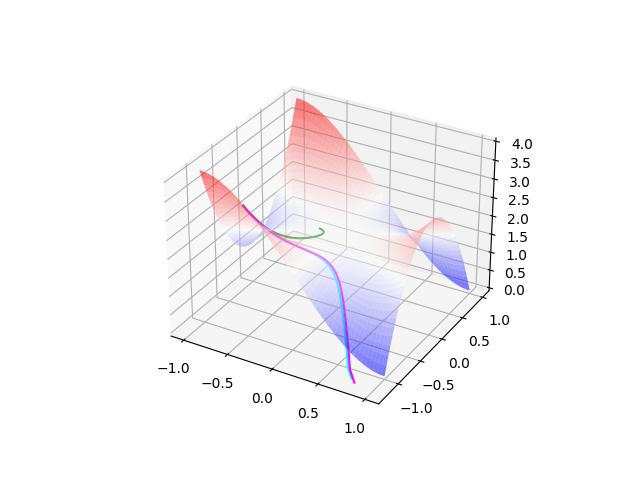

In [21]:
# let us compare SGD with RMSProp and ADAM!


# SGD
pos = torch.nn.Parameter(torch.Tensor([-0.55, -0.95]), requires_grad=True)
opt = torch.optim.SGD([pos], lr=0.01, momentum=0.4)
xs, ys, zs = drawpath(pos, opt, 200)

# RMSPROP
pos = torch.nn.Parameter(torch.Tensor([-0.55, -0.95]), requires_grad=True)
opt = torch.optim.RMSprop([pos], lr=0.01, alpha=0.99, eps=1e-08, momentum=0.4)
xr, yr, zr = drawpath(pos, opt, 200)

# ADAM
pos = torch.nn.Parameter(torch.Tensor([-0.55, -0.95]), requires_grad=True)
opt = torch.optim.Adam([pos], lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
xa, ya, za = drawpath(pos, opt, 200)

# clear old visualizations
plt.close('all')

# visualize the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, zmap, rstride=1, cstride=1, alpha=0.5,
                cmap='bwr', linewidth=0.4, antialiased=True)
ax.plot(xs, ys, zs, color='green')
ax.plot(xr, yr, zr, color='cyan')
ax.plot(xa, ya, za, color='magenta')
plt.show()

# It would seem that Adam and RMSProp are more similar to each other than SGD!
# Its worth noting that the path chosen with these two ultimately ends up
# at a much lower minima than the path chosen by SGD

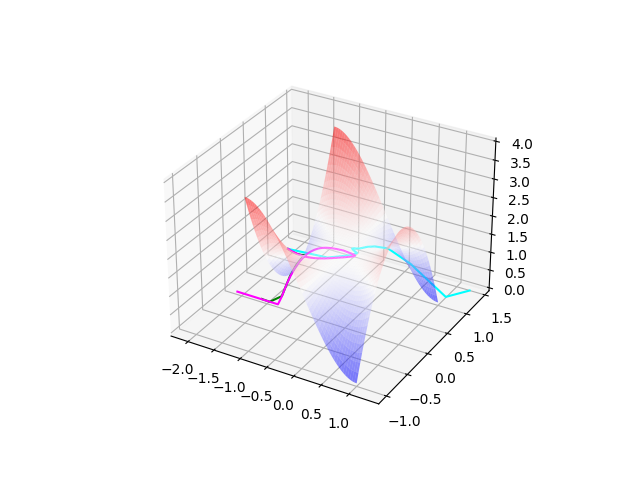

In [22]:
# let us change the starting value just a bit
# and increase the learning rate a bit

lrate = 0.04
startpos = [-0.54, -0.63]

# SGD
pos = torch.nn.Parameter(torch.Tensor(startpos), requires_grad=True)
opt = torch.optim.SGD([pos], lr=lrate, momentum=0.4)
xs, ys, zs = drawpath(pos, opt, 200)

# RMSPROP
pos = torch.nn.Parameter(torch.Tensor(startpos), requires_grad=True)
opt = torch.optim.RMSprop([pos], lr=lrate, alpha=0.99, eps=1e-08, momentum=0.4)
xr, yr, zr = drawpath(pos, opt, 200)

# ADAM
pos = torch.nn.Parameter(torch.Tensor(startpos), requires_grad=True)
opt = torch.optim.Adam([pos], lr=lrate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
xa, ya, za = drawpath(pos, opt, 200)

# clear old visualizations
plt.close('all')

# visualize the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, zmap, rstride=1, cstride=1, alpha=0.5,
                cmap='bwr', linewidth=0.4, antialiased=True)
ax.plot(xs, ys, zs, color='green')
ax.plot(xr, yr, zr, color='cyan')
ax.plot(xa, ya, za, color='magenta')
plt.show()

# can you explain in which way the optimizer paths differed?

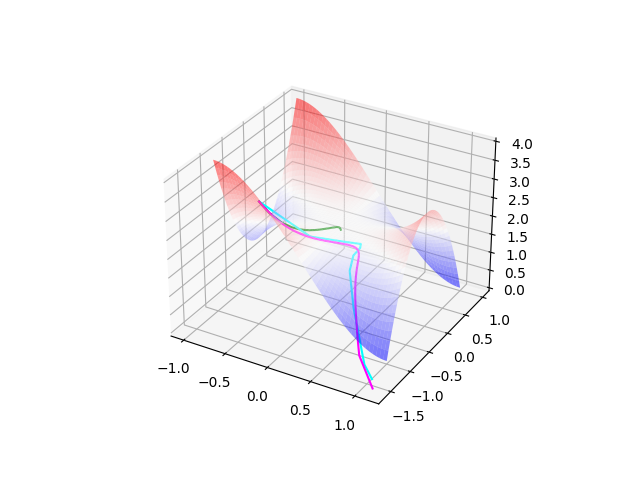

In [23]:
# let us change the starting value once again

lrate = 0.04
startpos = [-0.5195, -0.9]

# SGD
pos = torch.nn.Parameter(torch.Tensor(startpos), requires_grad=True)
opt = torch.optim.SGD([pos], lr=lrate, momentum=0.4)
xs, ys, zs = drawpath(pos, opt, 200)

# RMSPROP
pos = torch.nn.Parameter(torch.Tensor(startpos), requires_grad=True)
opt = torch.optim.RMSprop([pos], lr=lrate, alpha=0.99, eps=1e-08, momentum=0.4)
xr, yr, zr = drawpath(pos, opt, 200)

# ADAM
pos = torch.nn.Parameter(torch.Tensor(startpos), requires_grad=True)
opt = torch.optim.Adam([pos], lr=lrate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
xa, ya, za = drawpath(pos, opt, 200)

# clear old visualizations
plt.close('all')

# visualize the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, zmap, rstride=1, cstride=1, alpha=0.5,
                cmap='bwr', linewidth=0.4, antialiased=True)
ax.plot(xs, ys, zs, color='green')
ax.plot(xr, yr, zr, color='cyan')
ax.plot(xa, ya, za, color='magenta')
plt.show()

# In this simple 2D scenario it is easy to find many starting points which give SGD trouble
# we also notice that Adam has a smoother trajectory than RMSProp

# Hyperparameter Tuning

In the trivial 2 dimensional example above, we noticed how areas with flat gradients can give our optimizers trouble. Now, imagine that for each dimension we add to our input, the likelihood increases that the average gradient at any one point is zero. In addition, for problems with nonlinear objective functions, local minima increase in size. The small bit of good news is that if you find a very deep local minima, by virtue of high dimensional geometry, it is also likely that it is very close in depth to the global minima.

### Try improving the model performance by adjusting the optimizer

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [7]:
# let us define a relatively simple neural network with one hidden layer

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
print(model)



NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [8]:
# here we choose SGD as our optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [15]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.489449  [    0/60000]
loss: 1.466744  [ 6400/60000]
loss: 1.316502  [12800/60000]
loss: 1.396451  [19200/60000]
loss: 1.280751  [25600/60000]
loss: 1.275543  [32000/60000]
loss: 1.303636  [38400/60000]
loss: 1.219848  [44800/60000]
loss: 1.260617  [51200/60000]
loss: 1.175219  [57600/60000]
Test Error: 
 Accuracy: 63.3%, Avg loss: 1.194074 

Epoch 2
-------------------------------
loss: 1.263298  [    0/60000]
loss: 1.259701  [ 6400/60000]
loss: 1.093742  [12800/60000]
loss: 1.208135  [19200/60000]
loss: 1.081338  [25600/60000]
loss: 1.102293  [32000/60000]
loss: 1.141822  [38400/60000]
loss: 1.065818  [44800/60000]
loss: 1.106494  [51200/60000]
loss: 1.039584  [57600/60000]
Test Error: 
 Accuracy: 65.0%, Avg loss: 1.050179 

Epoch 3
-------------------------------
loss: 1.112053  [    0/60000]
loss: 1.128433  [ 6400/60000]
loss: 0.944893  [12800/60000]
loss: 1.086425  [19200/60000]
loss: 0.956418  [25600/60000]
loss: 0.983200  [32000/600